In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import random
import pickle
import numpy as np

In [ ]:
# download nltk -> Only used once
# nltk.download('stopwords')
# nltk.download('wordnet')

In [9]:
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [10]:
# read the train .csv file and just take two useful col TEXT & CLASS
def read_csv_file(file_path):
    data = pd.read_csv(file_path)
    text = data['TEXT']
    labels = data['CLASS']
    return text, labels

# read the train .xlsv file and just take two useful col TEXT & CLASS
def read_xlsv_file(file_path):
    data = pd.read_excel(file_path)
    text = data['TEXT']
    labels = data['CLASS']
    return text, labels

In [11]:
# 数据预处理函数，使用NLTK进行更全面的预处理
def preprocess_text(text):
    """
    对文本进行预处理，包括去除特殊字符、转换为小写、去除停用词和词形还原
    """
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    processed_text = []
    for t in text:
        # 去除特殊字符
        t = re.sub(r'[^a-zA-Z]', ' ', t)
        # 转换为小写
        t = t.lower()
        # 分词
        words = t.split()
        # 去除停用词和词形还原
        words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
        processed_text.append(' '.join(words))
    return processed_text

In [12]:
# Feature extraction and model training
def train_model_RMSprop(text, labels, num_epochs):
    text = preprocess_text(text)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(text)
    sequences = tokenizer.texts_to_sequences(text)
    max_sequence_length = max([len(seq) for seq in sequences])
    padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)
    X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, train_size=0.8, random_state=42)

    model = Sequential()
    model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=max_sequence_length))
    model.add(BatchNormalization())
    model.add(LSTM(128))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    optimizer = RMSprop(learning_rate=0.0001)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(X_train, y_train, batch_size=32, epochs=num_epochs, verbose=1, validation_split=0.2, callbacks=[early_stopping])
    evaluation = model.evaluate(X_test, y_test)

    print("Test set loss:", evaluation[0])
    print("Training set accuracy:", evaluation[1])

    return model, tokenizer, history

In [13]:
# Testing the trained model and calculating accuracy
def test_model(model, tokenizer, text, labels):
    # 数据预处理
    text = preprocess_text(text)
    
    # Tokenize the text data
    sequences = tokenizer.texts_to_sequences(text)
    padded_sequences = pad_sequences(sequences, maxlen=model.input_shape[1])

    # Making predictions using the model
    predictions = model.predict(padded_sequences)
    y_pred = (predictions > 0.5).astype(int).flatten()
    accuracy = accuracy_score(labels, y_pred)
    print("Testing set accuracy:", accuracy)

    # Create a table to compare the actual CLASS col and the predicted CLASS col
    df = pd.DataFrame({'Text': text, 'Predicted Label': y_pred, 'Actual Label': labels})
    print(df)

In [14]:
def plot_loss(history):
    # Get the loss values from training history
    loss = history.history['loss']

    # Create a list of epochs
    epochs = range(1, len(loss) + 1)

    # Plot the loss values
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [15]:
def main():
    train_text, train_labels = read_csv_file("./Topic_3_Data/Topic1-youtube_spam_train.csv")

    num_epochs = 100  # can change

    model, tokenizer, history = train_model_RMSprop(train_text, train_labels, num_epochs)
    
    plot_loss(history)

    test_text, test_labels = read_xlsv_file("./Topic_3_Data/Topic1-youtube_spam_test.xlsx")

    test_model(model, tokenizer, test_text, test_labels)

    model.save('youtube_spam_detection_model.h5')
    print("Model is saved as: youtube_spam_detection_model.h5")
    with open('tokenizer.pickle', 'wb') as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("Tokenizer save as tokenizer.pickle")

Epoch 1/100


C:\Users\hosanchau2\AppData\Local\anaconda3\envs\myenv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.5795 - loss: 0.6547 - val_accuracy: 0.4766 - val_loss: 0.6887
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.6621 - loss: 0.6157 - val_accuracy: 0.4453 - val_loss: 0.6876
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.7446 - loss: 0.5705 - val_accuracy: 0.4453 - val_loss: 0.6854
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.7863 - loss: 0.5097 - val_accuracy: 0.4453 - val_loss: 0.6829
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.8452 - loss: 0.4430 - val_accuracy: 0.4688 - val_loss: 0.6796
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9017 - loss: 0.3802 - val_accuracy: 0.5000 - val_loss: 0.6746
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9230 - loss: 0.3130 - val_accuracy: 0.5391 - val_loss: 0.6693
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9516 - loss: 0.2410 - val_accuracy: 0.5469 - val_l

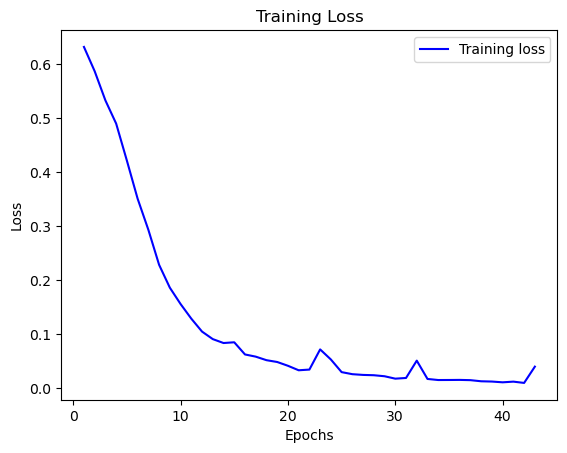

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Testing set accuracy: 0.9554455445544554
                                                  Text  Predicted Label  \
0    video started whole got dick stuck elevator ex...                0   
1                                   anyone sub channel                1   
2                                     prehistoric song                0   
3                            think smart headbutt face                0   
4                dislike one know real music ex enimen                0   
..                                                 ...              ...   
197                                check video youtube                1   
198                                check video youtube                1   
199                                check video youtube                1   
200                                check video youtube                1   
201    br attention subscribe channel br br gracias br                1   

     Actual Label  
0               0  
1               1 

In [16]:
if __name__ == '__main__':
    main()